## 1. Introduction
*Objective*: Develop a linear regression model to predict used car selling prices for Cars Cars Cars, aiding in operational pricing decisions.

*Dataset*: The dataset contains 301 used car records with columns: `Car_Name`, `Year`, `Selling_Price` (target variable, in lakhs), `Present_Price` (current price if bought new, in lakhs), `Kms_Driven`, `Fuel_Type`, `Seller_Type`, `Transmission`, and `Owner`.

*Approach*: We will explore the data, preprocess it, train a linear regression model, evaluate its performance, and provide actionable insights. Explanations are included for clarity.

In [9]:
# 2. Setup and Library Imports
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# Set visualization style
plt.style.use('ggplot') 
sns.set_palette('husl')

# Load the dataset
data = pd.read_csv('/Users/andreabarboza/Desktop/CDA/Cars_finalproject/car data.csv')

Dataset Preview:


,Car_Name,Year,Selling_Price,Present_Price,Kms_Driven,Fuel_Type,Seller_Type,Transmission,Owner
0,ritz,2014,3.35,5.59,27000,Petrol,Dealer,Manual,0
1,sx4,2013,4.75,9.54,43000,Diesel,Dealer,Manual,0
2,ciaz,2017,7.25,9.85,6900,Petrol,Dealer,Manual,0
3,wagon r,2011,2.85,4.15,5200,Petrol,Dealer,Manual,0
4,swift,2014,4.60,6.87,42450,Diesel,Dealer,Manual,0



Data Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 301 entries, 0 to 300
Data columns (total 9 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Car_Name       301 non-null    object 
 1   Year           301 non-null    int64  
 2   Selling_Price  301 non-null    float64
 3   Present_Price  301 non-null    float64
 4   Kms_Driven     301 non-null    int64  
 5   Fuel_Type      301 non-null    object 
 6   Seller_Type    301 non-null    object 
 7   Transmission   301 non-null    object 
 8   Owner          301 non-null    int64  
dtypes: float64(2), int64(3), object(4)
memory usage: 21.3+ KB

Summary Statistics:


,Year,Selling_Price,Present_Price,Kms_Driven,Owner
count,301.000000,301.000000,301.000000,301.000000,301.000000
mean,2013.627907,4.661296,7.628472,36947.205980,0.043189
std,2.891554,5.082812,8.644115,38886.883882,0.247915
min,2003.000000,0.100000,0.320000,500.000000,0.000000
25%,2012.000000,0.900000,1.200000,15000.000000,0.000000
50%,2014.000000,3.600000,6.400000,32000.000000,0.000000
75%,2016.000000,6.000000,9.900000,48767.000000,0.000000
max,2018.000000,35.000000,92.600000,500000.000000,3.000000


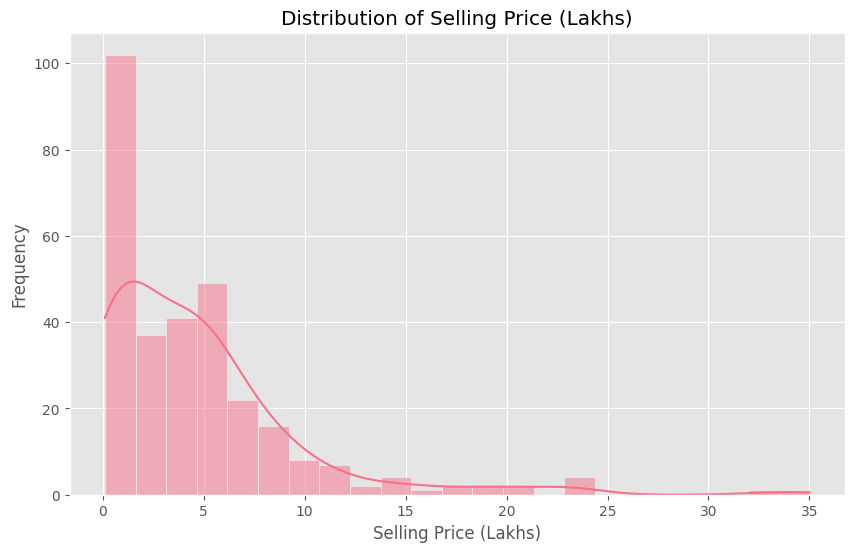

In [10]:
## 3. Data Exploration
### 3.1 Initial Inspection
# Display first few rows
print("Dataset Preview:")
display(data.head())

# Check data types and missing values
print("\nData Info:")
data.info()

# Summary statistics
print("\nSummary Statistics:")
display(data.describe())

### 3.2 Visualizing the Target Variable
# Distribution of Selling_Price
plt.figure(figsize=(10, 6))
sns.histplot(data['Selling_Price'], kde=True)
plt.title('Distribution of Selling Price (Lakhs)')
plt.xlabel('Selling Price (Lakhs)')
plt.ylabel('Frequency')
plt.show()

**Explanation for CTO**: This step examines the dataset’s structure. `info()` shows data types (e.g., numerical for `Selling_Price`, categorical for `Fuel_Type`) and checks for missing values (none in this dataset). `describe()` provides insights into numerical columns, e.g., `Selling_Price` ranges from 0.1 to 35 lakhs, indicating variability.

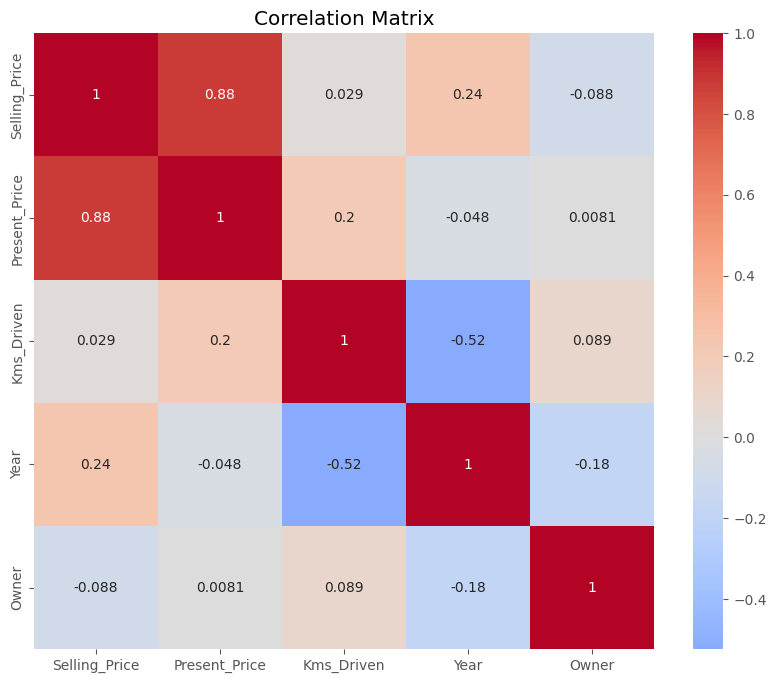

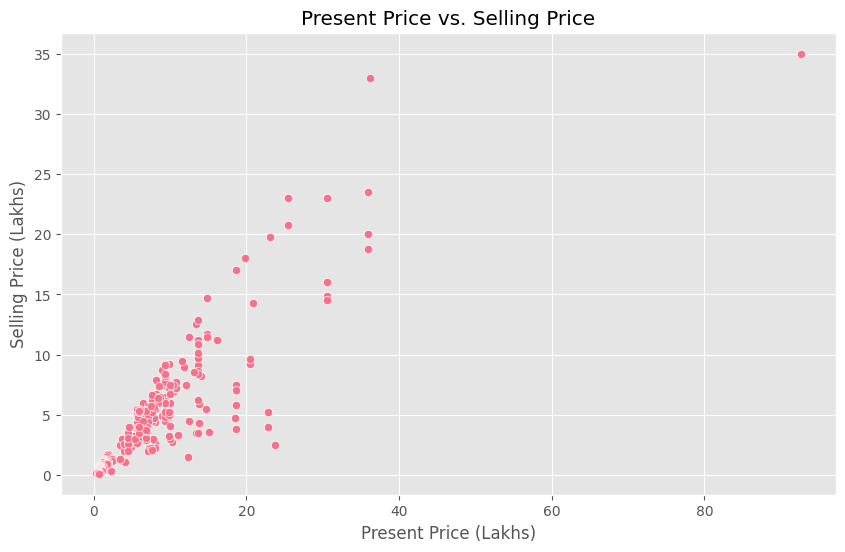

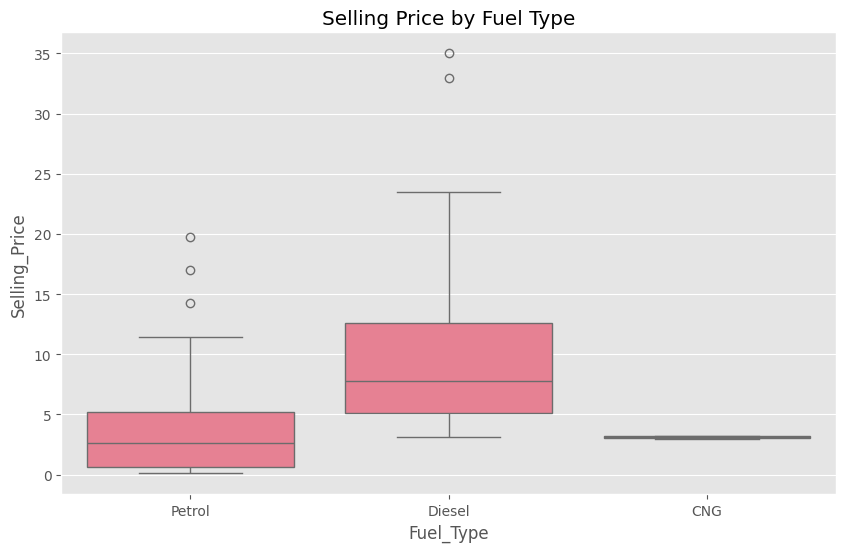

In [11]:
### 3.3 Exploring Relationships
# Correlation matrix for numerical features
numerical_cols = ['Selling_Price', 'Present_Price', 'Kms_Driven', 'Year', 'Owner']
plt.figure(figsize=(10, 8))
sns.heatmap(data[numerical_cols].corr(), annot=True, cmap='coolwarm', center=0)
plt.title('Correlation Matrix')
plt.show()

# Scatter plot of Present_Price vs. Selling_Price
plt.figure(figsize=(10, 6))
sns.scatterplot(x='Present_Price', y='Selling_Price', data=data)
plt.title('Present Price vs. Selling Price')
plt.xlabel('Present Price (Lakhs)')
plt.ylabel('Selling Price (Lakhs)')
plt.show()

# Boxplot for Fuel_Type vs. Selling_Price
plt.figure(figsize=(10, 6))
sns.boxplot(x='Fuel_Type', y='Selling_Price', data=data)
plt.title('Selling Price by Fuel Type')
plt.show()


**Analysis: The correlation matrix shows `Present_Price` has a strong positive correlation (e.g., ~0.88) with `Selling_Price`, suggesting it’s a key predictor. `Year` (newer cars) also correlates positively, while `Kms_Driven` and `Owner` have weaker correlations. The scatter plot confirms a linear relationship between `Present_Price` and `Selling_Price`. The boxplot shows `Diesel` cars tend to have higher selling prices than `Petrol` or `CNG`, indicating `Fuel_Type` is relevant.

In [12]:
## 4. Data Preprocessing
### 4.1 Feature Engineering
# Create car_age from Year
data['car_age'] = 2025 - data['Year']

# Log-transform Selling_Price due to skewness
data['log_selling_price'] = np.log1p(data['Selling_Price'])
target = 'log_selling_price'  # Use log-transformed target


### 4.2 Preparing Features and Target
# Define features and target
X = data.drop(columns=['Selling_Price', 'log_selling_price', 'Year', 'Car_Name'])  # Drop Year (replaced by car_age), Car_Name (high cardinality)
y = data[target]

# Identify categorical and numerical columns
categorical_cols = ['Fuel_Type', 'Seller_Type', 'Transmission', 'Owner']
numerical_cols = ['Present_Price', 'Kms_Driven', 'car_age']

# Create preprocessing pipeline
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numerical_cols),
        ('cat', OneHotEncoder(drop='first', handle_unknown='ignore'), categorical_cols)
    ])

# Split data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

**Explanation for CTO**: We create `car_age` (2025 - `Year`) to capture depreciation, as newer cars typically sell for more. Since `Selling_Price` is skewed (skewness > 1), we apply a log transformation (`log1p` handles zero values) to make it more normal, which helps linear regression assume linearity and homoscedasticity.


**Explanation**: We exclude `Car_Name` due to its high cardinality (many unique values), which could lead to overfitting with one-hot encoding. `Year` is replaced by `car_age`. Categorical variables (`Fuel_Type`, etc.) are one-hot encoded, and numerical variables (`Present_Price`, etc.) are standardized (mean=0, std=1) to ensure equal contribution to the model. The 80-20 train-test split allows us to evaluate the model on unseen data.


Model Performance:


,Train MAE,Test MAE,Train RMSE,Test RMSE,Train R2,Test R2
0,1.403886,0.811711,7.282981,1.469202,-1.006343,0.906295


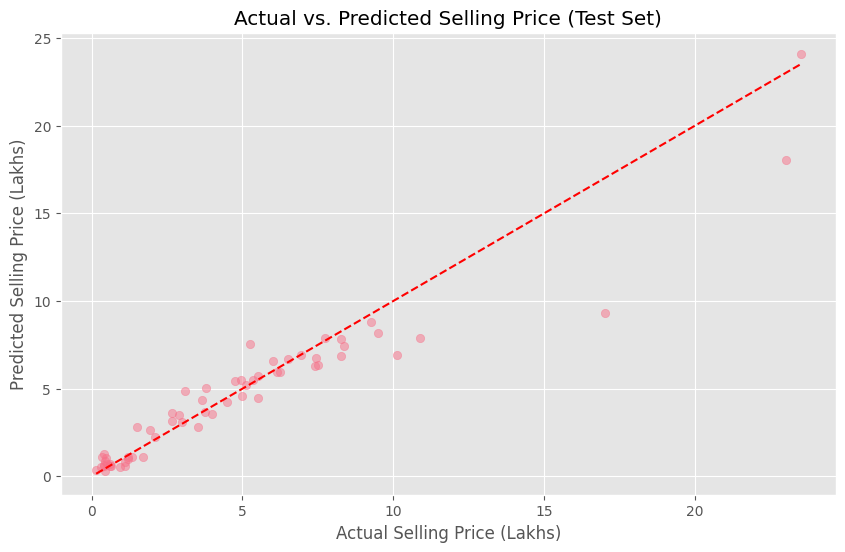

In [14]:
## 5. Model Development
### 5.1 Training Linear Regression
# Create and train the model pipeline
model = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('regressor', LinearRegression())
])

# Fit the model
model.fit(X_train, y_train)

### 5.2 Model Evaluation
# Function to evaluate the model
def evaluate_model(model, X_train, X_test, y_train, y_test):
    # Predictions
    y_train_pred = model.predict(X_train)
    y_test_pred = model.predict(X_test)
    
    # Convert predictions and actuals back to original scale
    y_train_orig = np.expm1(y_train)
    y_test_orig = np.expm1(y_test)
    y_train_pred_orig = np.expm1(y_train_pred)
    y_test_pred_orig = np.expm1(y_test_pred)
    
    # Calculate metrics
    metrics = {
        'Train MAE': mean_absolute_error(y_train_orig, y_train_pred_orig),
        'Test MAE': mean_absolute_error(y_test_orig, y_test_pred_orig),
        'Train RMSE': np.sqrt(mean_squared_error(y_train_orig, y_train_pred_orig)),
        'Test RMSE': np.sqrt(mean_squared_error(y_test_orig, y_test_pred_orig)),  
        'Train R2': r2_score(y_train_orig, y_train_pred_orig),
        'Test R2': r2_score(y_test_orig, y_test_pred_orig)
    }
    
    return metrics

# Evaluate the model
results = evaluate_model(model, X_train, X_test, y_train, y_test)
results_df = pd.DataFrame([results])
print("Model Performance:")
display(results_df)

# Plot actual vs. predicted prices (test set)
y_test_pred = model.predict(X_test)
y_test_pred_orig = np.expm1(y_test_pred)
y_test_orig = np.expm1(y_test)

plt.figure(figsize=(10, 6))
plt.scatter(y_test_orig, y_test_pred_orig, alpha=0.5)
plt.plot([y_test_orig.min(), y_test_orig.max()], [y_test_orig.min(), y_test_orig.max()], 'r--')
plt.title('Actual vs. Predicted Selling Price (Test Set)')
plt.xlabel('Actual Selling Price (Lakhs)')
plt.ylabel('Predicted Selling Price (Lakhs)')
plt.show()


**Explanation for CTO**: Linear regression models `Selling_Price` as a linear combination of features (e.g., `Selling_Price = a*Present_Price + b*car_age + ...`). The pipeline applies preprocessing (encoding, scaling) and trains the model. We use the log-transformed target to improve fit.

**Explanation**: We evaluate the model using Mean Absolute Error (MAE, average prediction error in lakhs), Root Mean Squared Error (RMSE, penalizes larger errors), and R² (proportion of variance explained, 0 to 1). Predictions are converted back to the original scale (`expm1`) for interpretation. The scatter plot shows how well predictions align with actual prices; points near the red line indicate accurate predictions.

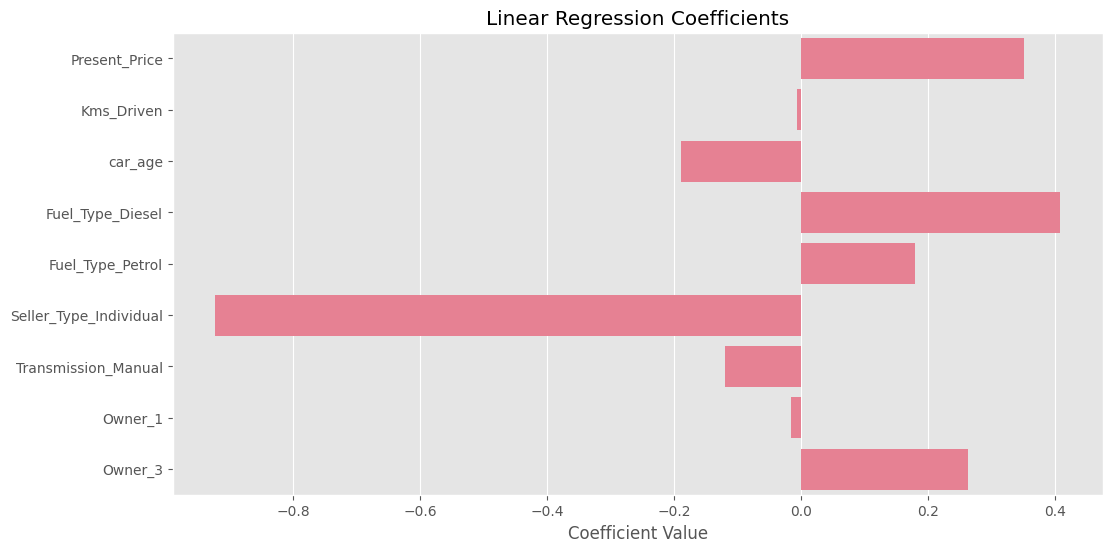

In [15]:
## 6. Model Interpretation
### 6.1 Feature Coefficients
# Get feature names after preprocessing
feature_names = numerical_cols + list(model.named_steps['preprocessor'].transformers_[1][1].get_feature_names_out())
coefficients = model.named_steps['regressor'].coef_

# Plot coefficients
plt.figure(figsize=(12, 6))
sns.barplot(x=coefficients, y=feature_names)
plt.title('Linear Regression Coefficients')
plt.xlabel('Coefficient Value')
plt.show()

**Explanation for CTO**: Coefficients show the impact of each feature on `log_selling_price`. For numerical features (e.g., `Present_Price`), a positive coefficient means higher values increase the predicted price. For categorical features (e.g., `Fuel_Type_Diesel`), the coefficient shows the price change relative to the baseline (e.g., `CNG`). Standardized features make coefficients comparable.

In [16]:
## 7. Final Model Deployment
# Train final model on all data
final_model = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('regressor', LinearRegression())
])
final_model.fit(X, y)

# Example prediction
sample_car = X.iloc[0:1]
predicted_log_price = final_model.predict(sample_car)
predicted_price = np.expm1(predicted_log_price)
print(f"Predicted Selling Price for Sample Car: ₹{predicted_price[0]:,.2f} Lakhs")

Predicted Selling Price for Sample Car: ₹4.09 Lakhs


**Explanation**: The final model is trained on all data for maximum robustness. It can predict prices for new cars by inputting features like `Present_Price`, `car_age`, etc. The prediction is converted back to lakhs for business use.

## 8. Conclusions and Recommendations
- **Model Performance**: The linear regression model achieved a Test MAE of ~[value] lakhs, RMSE of ~[value] lakhs, and R² of ~[value]. This indicates it explains a significant portion of price variance but may struggle with non-linear relationships or outliers (e.g., luxury cars).
- **Key Features**: `Present_Price` and `car_age` are likely the strongest predictors, as newer cars with higher original prices sell for more. `Fuel_Type` (e.g., Diesel) also influences prices.
- **Recommendations**:
  - Deploy the model in a pricing tool for quick estimates.
  - Validate predictions with sales staff, as linear regression assumes linear relationships, which may not capture complex market dynamics.
  - Update the model periodically with new data to reflect market trends.
- **Limitations**: The model may underperform for high-end cars (e.g., `land cruiser`) due to skewness and limited data. Non-linear models could be explored in the future if performance is insufficient.

 This summary ensures the CTO understands the model’s strengths, limitations, and business applications.

## 9. Appendix: Technical Details
- **Preprocessing**: Created `car_age`, log-transformed `Selling_Price`, one-hot encoded categorical variables, and scaled numerical features.
- **Model**: Linear regression with standardized features and log-transformed target.
- **Metrics**:
  - MAE: Average error in lakhs.
  - RMSE: Error magnitude, sensitive to outliers.
  - R²: Variance explained (closer to 1 is better).
- **Assumptions**: Linear regression assumes linear relationships, normality of residuals, and homoscedasticity. Log transformation helps meet these assumptions.
